引入套件

In [2]:
import monpa
from monpa import utils
import csv
from collections import Counter
import pandas as pd
import pickle
import re
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import feature_selection as fs
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold


讀取資料

In [3]:
%cd -q C:\Users\vinc2\OneDrive\Desktop\大數據\bda2024_mid_dataset
news_1 = pd.read_csv("bda2024_202203-202402_內容數據_新聞1.csv")
news_2 = pd.read_csv("bda2024_202203-202402_內容數據_新聞2.csv")
news_df = pd.concat([news_1, news_2], ignore_index=True)

C:\Users\vinc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
transaction_df = pd.read_csv("bda2024_微股力_個股交易數據-2年.csv")
report_df = pd.read_csv("bda2024_微股力_財報數據-2年.csv")
chip_df = pd.read_csv("bda2024_微股力_籌碼數據-2年.csv")
social_df = pd.read_csv("bda2024_微股力_社群PKTD-2年.csv")
transaction_df['stock_symbol'] = transaction_df['stock_symbol'].astype(str)
chip_df['stock_symbol'] = chip_df['stock_symbol'].astype(str)    # Repair mixed data types

C:\Users\vinc2\AppData\Local\Temp\ipykernel_15788\321925132.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction_df = pd.read_csv("bda2024_微股力_個股交易數據-2年.csv")
C:\Users\vinc2\AppData\Local\Temp\ipykernel_15788\321925132.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  chip_df = pd.read_csv("bda2024_微股力_籌碼數據-2年.csv")


In [5]:
transaction_df[transaction_df["stock_name"] == "聯發科"].sort_values(by=['date'])

,stock_name,stock_symbol,open,high,low,close,volume,date
60462,聯發科,2454,1105.0,1120.0,1095.0,1100.0,5544,2022-03-01 00:00:00
61191,聯發科,2454,1105.0,1105.0,1070.0,1080.0,3703,2022-03-02 00:00:00
61192,聯發科,2454,1085.0,1100.0,1065.0,1080.0,3873,2022-03-03 00:00:00
61193,聯發科,2454,1060.0,1060.0,1025.0,1025.0,6621,2022-03-04 00:00:00
61194,聯發科,2454,985.0,995.0,970.0,972.0,11349,2022-03-07 00:00:00
...,...,...,...,...,...,...,...,...
1074519,聯發科,2454,960.0,985.0,960.0,982.0,8929,2024-02-20 00:00:00
1071064,聯發科,2454,972.0,986.0,972.0,981.0,5895,2024-02-21 00:00:00
1073582,聯發科,2454,988.0,1020.0,988.0,1015.0,11143,2024-02-22 00:00:00
1071199,聯發科,2454,1035.0,1100.0,1010.0,1100.0,24851,2024-02-23 00:00:00


分類資料集

In [6]:
def get_next_date(input_date, dates_list):
    index = sum(1 for d in dates_list if d < input_date)
    if index >= len(dates_list):
        return -1, -1
    else:
        return index, dates_list[index]

def get_answer(stock_name, input_date, n_days_after, threshold):
    dates_list = sorted(transaction_df.loc[(transaction_df['stock_name']==stock_name)]['date'])
    i, _ = get_next_date(input_date, dates_list)

    if i == -1 or i >= len(dates_list) or i + n_days_after >= len(dates_list):
        return 2
    
    open_date = dates_list[i]
    close_date = dates_list[i + n_days_after]
    
    
    open_price = transaction_df.loc[(transaction_df['date']==open_date) & (transaction_df['stock_name']==stock_name)]['open'].iloc[0]
    close_price = transaction_df.loc[(transaction_df['date']==close_date) & (transaction_df['stock_name']==stock_name)]['close'].iloc[0]
    price_change = (close_price - open_price) / open_price
    if price_change >= threshold:
        return 1     # buy
    elif price_change <= -threshold:
        return -1    # sell
    else:
        return 0     # hold

In [7]:
def stock_price(news):    
    news['stock_name'] = '聯發科'
    news['category'] = news.apply(lambda r: get_answer(r['stock_name'], r['post_time'], 10, 0.02), axis = 1)

    return news

時間篩選

In [8]:
#利用月份過濾資料
def train_filter(news, start_time):
    filtered_news_list = []

    for i in news.index:
        title = news["title"][i]
        content = news["content"][i]
        date = news["post_time"][i]
        if (((isinstance(title, str) and '聯發科' in title) or (isinstance(content, str) and '聯發科' in content)) and (isinstance(date, str) and date[:7] in start_time)):
            filtered_news_list.append(news.loc[i])
    if len(filtered_news_list) == 0:
        return ['0'] 
    filtered_news = pd.DataFrame(filtered_news_list)
    return stock_price(filtered_news)

In [9]:
#利用天過濾資料
def filter_test(news, test_time):
    filtered_news_list = []

    for i in news.index:
        title = news["title"][i]
        content = news["content"][i]
        date = news["post_time"][i]
        if (((isinstance(title, str) and '聯發科' in title) or (isinstance(content, str) and '聯發科' in content)) and (isinstance(date, str) and date[:10] == test_time)):
            filtered_news_list.append(news.loc[i])
    if len(filtered_news_list) == 0:
        return ['0']
    filtered_news = pd.DataFrame(filtered_news_list)
    return stock_price(filtered_news)

文字處理

In [10]:
#stopwords removal
stopwords = []
with open('stopwords_zh.txt', 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f]

def tokenize_and_remove_stopwords(text):
    words = monpa.cut(text)
    words = [word for word in words if word not in stopwords and not re.match(r'\s+', word) and not word.isdigit()]
    return words

前處理

In [11]:
#斷詞且轉為tf-idf向量
def preprocessing(news):
    documents = []
    labels = []

    for index, row in news.iterrows():
        if row['category'] in [1, -1]:
            # stopwords removal
            title_tokens = tokenize_and_remove_stopwords(row['title'])
            content_tokens = tokenize_and_remove_stopwords(row['content'])
            
            title_content = ' '.join(title_tokens + content_tokens)
            
            documents.append(title_content)
            
            labels.append(row['category'])

    def preprocess_text(text):
        text = re.sub(r'\d+', '', text)  # 去除数字
        text = re.sub(r'[^\w\s]', '', text)  # 去除标点符号
        text = re.sub(r'\s+', ' ', text)  # 去除多余空格
        return text.lower()  # 转换为小写

    # 对文档进行预处理
    documents = [preprocess_text(doc) for doc in documents]
    if '' in documents:
        documents.remove('')

    if len(documents) == 0:
        return 0,0,0

    vectorizer = TfidfVectorizer()
    vectorized_doc = vectorizer.fit_transform(documents)

    return documents, vectorized_doc, labels

特徵選取

In [12]:
#利用chi-square進行feature selection
def feature_selection(doc, X, lab):
    vectorizer = TfidfVectorizer()
    vectorized_doc = vectorizer.fit_transform(doc)

    #X_train, X_test, y_train, y_test = train_test_split(X, lab, test_size = 0.3, random_state=42)

    #X_train = sorted(X_train)[:100]
    selector = fs.SelectKBest(fs.chi2 , k = 500)
    #selector = fs.SelectKBest(fs.mutual_info_classif , k = 500)
    #selector = fs.SelectKBest(fs.f_classif, k=1400)
    #selector = VarianceThreshold(threshold=0.00009)
    #estimator = LinearRegression()
    #selector = RFE(estimator, n_features_to_select=100)
    #base_estimator = RandomForestClassifier()
    #selector = StabilitySelection(base_estimator=base_estimator,n_jobs=-1,n_bootstraps=10,  random_state=42)

    X_selected = selector.fit_transform(X, lab)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = [vectorizer.get_feature_names_out()[i] for i in selected_feature_indices]

    return X_selected, selected_feature_indices
    #selected_features_df = pd.DataFrame(selected_feature_names, columns=['Selected Features'])
    #selected_features_df.to_csv('selected_features.csv', index=False)

向量空間投射

In [13]:
#將測試資料集放入利用feature selection做出的向量空間
def vector_space(selected_feature_indices, X_test):
    data = []
    indices = []
    indptr = []

    ind = 0
    for j in range(X_test.shape[0]):
        indptr.append(ind)
        for k in range(len(X_test[j].indices)):
            if X_test[j].indices[k] in selected_feature_indices:
                data.append(X_test[j].data[k])
                indices.append(np.where(selected_feature_indices == X_test[j].indices[k])[0][0])
                ind += 1

    indptr.append(len(data))

    data = np.array(data)
    indices= np.array(indices)
    indptr = np.array(indptr)

    selected_feature_test = csr_matrix((data, indices, indptr), shape = (X_test.shape[0], len(selected_feature_indices)))
    return selected_feature_test

訓練模型

In [14]:
#訓練並測試SVC模型
def construct_model(X_selected, lab, y_test, selected_feature_test):
    classifier = SVC(kernel='linear') 
    #classifier = KNeighborsClassifier(n_neighbors = 10) 
    #classifier = MLPClassifier(hidden_layer_sizes=(500, 50), max_iter = 300)
    #classifier = MultinomialNB()
    #classifier = RandomForestClassifier()
    #classifier = LogisticRegression(max_iter=100)
    #classifier = GradientBoostingClassifier()

    classifier.fit(X_selected, lab)
    y_pred = classifier.predict(selected_feature_test)

    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return sum(y_pred), y_pred, conf_matrix

 

分析

In [15]:
#分析預測結果
def analysis(y_test, y_pred, conf_matrix):  
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_pred_encoded = label_encoder.transform(y_pred)  

    #accuracy
    accuracy = (conf_matrix.diagonal().sum()) / len(y_test_encoded)

    # F1 score
    f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

    #precision
    precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted')

    #recall
    recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted')
    return accuracy, f1, precision, recall


訓練資料及處理

In [16]:
def training_model(start_time):
    train_news = train_filter(news_df, start_time)
    doc, X_train, y_train = preprocessing(train_news)
    X_selected, selected_feature_indices= feature_selection(doc, X_train, y_train)

    return selected_feature_indices, X_selected, y_train

測試資料及處理

In [17]:
def testing_model(test_time, selected_feature_indices):
    test_news = filter_test(news_df, test_time)
    if '0' in test_news:
        return 0, 0
    _, X_test, y_test = preprocessing(test_news)
    try:
        if X_test == 0:
            return 0, 0
    except:
        feature_test = vector_space(selected_feature_indices, X_test)
    
    return feature_test, y_test

圖形展示

In [18]:
def draw_confusion_matrix(conf_matrix):
    class_labels = ['-1',  '+1']

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="crest", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

模型評估

In [19]:
train_time = ['2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-01']
test_time = ['2023-10', '2023-11', '2023-12']

train_news = train_filter(news_df, train_time)
doc, X_train, y_train = preprocessing(train_news)
X_selected, selected_feature_indices= feature_selection(doc, X_train, y_train)
test_news = train_filter(news_df, test_time)
_, X_test, y_test = preprocessing(test_news)
feature_test = vector_space(selected_feature_indices, X_test)


Accuracy: 0.7373737373737373
F1 score: 0.6355233002291826
Precision: 0.8070500927643784
Recall 0.7373737373737373


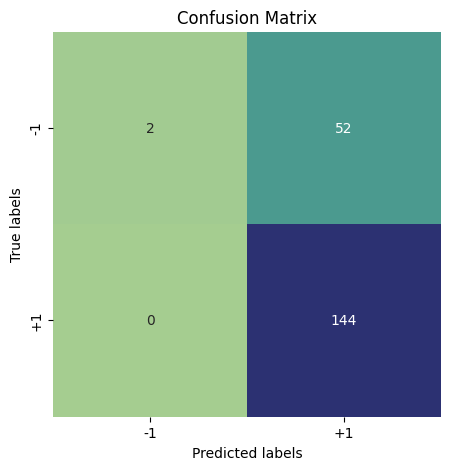

[[  2  52]
 [  0 144]]


In [20]:
_, y_pred, conf_matrix = construct_model(X_selected, y_train, y_test, feature_test)
accuracy, f1, precision, recall = analysis(y_test, y_pred, conf_matrix)
print("Accuracy:", accuracy)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall", recall)
draw_confusion_matrix(conf_matrix)
print(conf_matrix)

回測

In [21]:
from dateutil.relativedelta import relativedelta

start_date = datetime.date(2022,6,1)
end_date = datetime.date(2024,2,29)
train_date = ['a']
current_date = start_date
result = []

while current_date <= end_date:
    test_date = current_date.strftime("%Y-%m-%d")
    new_train_date = [(current_date - relativedelta(months=3)).strftime("%Y-%m"), (current_date - relativedelta(months=2)).strftime("%Y-%m"), (current_date - relativedelta(months=1)).strftime("%Y-%m")]
    if train_date[0] != new_train_date[0]:
        train_date = new_train_date
        selected_feature_indices, X_train, y_train = training_model(train_date)
    
    X_test, y_test = testing_model(test_date, selected_feature_indices)
    try:
        if X_test == 0:
            score = 0
    except:
        score, _, _ = construct_model(X_train, y_train, y_test, X_test)
    result.append([test_date, score])
    current_date = current_date + datetime.timedelta(days=1)
    
for i in range(len(result)):
    if result[i][1] > 0:
        result[i][1] = 1
    elif result[i][1] < 0:
        result[i][1] = -1
    else:
        result[i][1] = 0
result_df = pd.DataFrame(result)
print(result_df)
result_df.to_csv('result.csv', sep=',', encoding='utf-8')



C:\Users\vinc2\AppData\Local\Temp\ipykernel_15788\2936621898.py:16: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  X_test, y_test = testing_model(test_date, selected_feature_indices)
C:\Users\vinc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\vinc2\AppData\Local\Temp\ipykernel_15788\2936621898.py:16: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  X_test, y_test = testing_model(test_date, selected_feature_indices)
C:\Users\vinc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3577: S

              0  1
0    2022-06-01 -1
1    2022-06-02 -1
2    2022-06-03 -1
3    2022-06-04 -1
4    2022-06-05 -1
..          ... ..
634  2024-02-25  0
635  2024-02-26  0
636  2024-02-27  0
637  2024-02-28  0
638  2024-02-29  0

[639 rows x 2 columns]


In [26]:
result_df.columns = ['date', 'result']
print(result_df)
result_df.to_csv('result.csv', sep=',', encoding='utf-8')

           date  result
0    2022-06-01      -1
1    2022-06-02      -1
2    2022-06-03      -1
3    2022-06-04      -1
4    2022-06-05      -1
..          ...     ...
634  2024-02-25       0
635  2024-02-26       0
636  2024-02-27       0
637  2024-02-28       0
638  2024-02-29       0

[639 rows x 2 columns]
